In [59]:
import pandas as pd
import numpy as np
data = pd.read_csv('/home/DS-DH/notebooks/digitalHouse/properatti.csv')

In [73]:
matriz = pd.read_csv('/home/DS-DH/notebooks/digitalHouse/matriz.csv',sep='|')

In [74]:
data_= pd.read_csv('/home/DS-DH/notebooks/digitalHouse/matriz.csv',sep='|')

In [75]:
def outliers(p_data):


    data_modificada = p_data

    # GENERO CULUMNA DE MEDIAS AGRUPANDO POR PCIA, BARRIO, TIPO DE PROPIEDAD
    data_modificada ['media_supTotal'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_total'].transform('mean')
    data_modificada ['media_supCubierta'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_cubierta_m2'].transform('mean')
    data_modificada ['media_PrecioM2'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_m2'].transform('mean')
    data_modificada ['media_PrecioAproxUSD'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_aprox_usd'].transform('mean')


    #GENERO COLUMNA DE STD AGRUPANDO POR PCIA, BARRIO, TIPO DE PROPIEDAD
    data_modificada ['std_supTotal'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_total'].transform('std')
    data_modificada ['std_supCubierta'] = data_modificada.groupby(['localidad','barrio','propiedad'])['superficie_cubierta_m2'].transform('std')
    data_modificada ['std_PrecioM2'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_m2'].transform('std')
    data_modificada ['std_PrecioAproxUSD'] = data_modificada.groupby(['localidad','barrio','propiedad'])['precio_aprox_usd'].transform('std')


    #GENERO COLUMNA CON LA FORMULA DE CHEUVENET PARA EL CALCULO DE OUTLIERS
    data_modificada ['supTotal_criterio_cheuvenet'] = (abs(data_modificada.superficie_total-data_modificada.media_supTotal))/(data_modificada.std_supTotal)
    data_modificada ['supCubierta_criterio_cheuvenet'] = (abs(data_modificada.superficie_cubierta_m2-data_modificada.media_supCubierta))/(data_modificada.std_supCubierta)
    data_modificada ['priceM2_criterio_cheuvenet'] = (abs(data_modificada.precio_m2-data_modificada.media_PrecioM2))/(data_modificada.std_PrecioM2)
    data_modificada ['priceAprox_criterio_cheuvenet'] = (abs(data_modificada.precio_aprox_usd-data_modificada.media_PrecioAproxUSD))/(data_modificada.std_PrecioAproxUSD)

    
    
    #  % OUTLIERS SUPERFICIES TOTALES
    data_modificada.loc[data_modificada.supTotal_criterio_cheuvenet>2].shape[0]/data_modificada.shape[0]    
    data_modificada.superficie_total.loc[data_modificada.supTotal_criterio_cheuvenet>2] = np.nan
    
    
    #  % OUTLIERS SUPERFICIES CUBIERTAS
    data_modificada.loc[data_modificada.supCubierta_criterio_cheuvenet>2].shape[0]/data_modificada.shape[0] 
    data_modificada.superficie_cubierta_m2.loc[data_modificada.supCubierta_criterio_cheuvenet>2] = np.nan
    
    
    #  % OUTLIERS DE PRECIOS APROX USD
    data_modificada.precio_aprox_usd.loc[data_modificada.priceAprox_criterio_cheuvenet>2].shape[0]/data_modificada.shape[0]   
    data_modificada.precio_aprox_usd.loc[data_modificada.priceAprox_criterio_cheuvenet>2] = np.nan
    
    #  % OUTLIERS DE PRECIOS POR M2
    data_modificada.loc[data_modificada.priceM2_criterio_cheuvenet>2].shape[0]/data_modificada.shape[0]
    data_modificada.precio_m2.loc[data_modificada.priceM2_criterio_cheuvenet>2] = np.nan
    
    
    
    return data_modificada 

In [76]:
data_ = outliers(matriz)

In [ ]:
#GENERO AMBIENTES DE MATRIZ
#data_['ambientes']=data_.merge(matriz,how='left', left_index=True, right_index=True)['ambientes']

#GENERO DUMMYS DE AMBIENTES
data_['1_AMBIENTE'] = (data_.ambientes>=1)&(data_.ambientes<2)
data_['2_AMBIENTE'] = (data_.ambientes>=2)&(data_.ambientes<3)
data_['3_AMBIENTE'] = (data_.ambientes>=3)&(data_.ambientes<4)
data_['4_AMBIENTE'] = (data_.ambientes>=4)&(data_.ambientes<5)
data_['5_AMBIENTE'] = (data_.ambientes>=5)&(data_.ambientes<6)
data_['6_AMBIENTE'] = (data_.ambientes>=6)&(data_.ambientes<7)
data_['7_AMBIENTE'] = (data_.ambientes>=7)&(data_.ambientes<8)


data_[['1_AMBIENTE','2_AMBIENTE','3_AMBIENTE','4_AMBIENTE', '5_AMBIENTE','6_AMBIENTE','7_AMBIENTE']] = data_[['1_AMBIENTE','2_AMBIENTE','3_AMBIENTE','4_AMBIENTE', '5_AMBIENTE','6_AMBIENTE','7_AMBIENTE']].applymap(lambda x : 1 if (x) else 0)


#GENERO DUMMYS TIPO DE PROPIEDAD 
data_['CASA'] = data_.propiedad.str.contains('house')
data_['PH'] =  data_.propiedad.str.contains('PH')
data_['DTO'] = data_.propiedad.str.contains('apartment')
data_[['CASA','PH','DTO']] = data_[['CASA','PH','DTO']].applymap(lambda x : 1 if x else 0)


#ELIMINO REGISTROS NULOS DE VARIABLES A UTILIZAR EN EL MODELO
data_=data_[data_.precio_m2.notnull()]
data_=data_[data_.superficie_total.notnull()]
data_=data_[data_.ambientes.notnull()]


#GENERO DUMMYS DE BARRIOS

#QUITO NULOS DE LA COLUMNA STATE_NAME
data_ = data_[data_.barrio.notnull()]


#CREO LISTA DE BARRIOS 
barrios = data_[data_.localidad.str.contains('capital')].barrio.unique()


#GENERO DUMMYS
for barrio in barrios:
    indices_barrios = (data_.index[data_.barrio.str.contains(barrio)])
    barrio = barrio.lower().replace(' ','_')
    df = data_
    df.barrio = df.barrio.apply(lambda x : x.lower().replace(' ','_'))
    df[barrio] = df.barrio.str.contains(barrio)



numero_barrios = len(data_.barrio[data_.localidad.str.contains('capital')].unique())
indices_dummys_barrios = data_.shape[1]-numero_barrios

#CREO EL DATAFRAME CON LAS DUMMYS DE BARRIOS
dummys_barrios = data_.iloc[:,indices_dummys_barrios:]


dummys_barrios = dummys_barrios.applymap(lambda x : 1 if (x) else 0)


#GENERO DUMMYS DE BARRIOS EN EL DATAFRAME
data_.iloc[:,indices_dummys_barrios:] = dummys_barrios


In [119]:
#SKLEARN

#GENERO VARIABLES INDEPENDIENTES
x_feactures = data_.iloc[:,31:]
df1 = data_['superficie_total']
xs = pd.concat([df1,x_feactures],axis=1)

In [116]:

#GENERO VARIABLE DEPENDIENTE
y = data_.precio_m2

In [120]:
#TRANSFORMO VARIABLES INDEPENDIENTES EN FORMATO MATRIZ
xs = xs.as_matrix()


#TRANSFORMO VARIABLE DEPENDIENTE EN FORMATO MATRIZ
y = y.as_matrix()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [121]:
#IMPORTAR LIBRERIAS DE SKLEARN
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [132]:
#PARTICIONAR DATOS DE ENTRENAMIENTO Y TESTING
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.2)

In [133]:
#FIT 
modelo = linear_model.LinearRegression()
modelo.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [134]:
#PREDECIR DATOS "Y" DE "X" TEST 
y_predict = modelo.predict(x_test)


In [135]:
#PENDIENTES
pendientes = modelo.coef_

In [136]:
#ORDENADA 
ordenada = modelo.intercept_

In [141]:
#R2
'EL RESULTADO DEL MODELO ES DE {}'.format(modelo.score(x_train,y_train))

'EL RESULTADO DEL MODELO ES DE 0.49694566739918206'

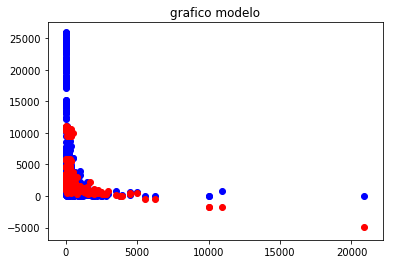

In [142]:
import matplotlib.pyplot as plt

#GENERO EJE X -> SUPERFICIE TOTAL
x1 = x_test[:,0]

#GENERO EJE Y -> PRECIO M2 DE TEST
x2 = y_test

# EJE Y -> PRECIO M2 PREDICHO
x3 = y_predict


#PLOT
plt.scatter(x1,x2,label='test modelo', color='blue')
plt.scatter(x1,x3,label='prediccion modelo', color='red')
plt.title('grafico modelo')
plt.show()